<a href="https://colab.research.google.com/github/KolatimiDave/Leaf-Disease-Classification/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explanation/ Procedure of Model

- Import Data using ImageDataGenerator
- Then Data Exploration
- Then I create a basic CNN model architecture
- Then I use [transfer learning](https://towardsdatascience.com/what-is-deep-transfer-learning-and-why-is-it-becoming-so-popular-91acdcc2717a), such that the basic model learns. 
- I use early stopping callback in keras to stop the model from training after a patience of 10 epochs.
- Finally I make a visual plot of the training and validation accuracies.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
SEED = 42

In [3]:
import numpy as np
import tensorflow
tensorflow.random.set_seed(SEED)
np.random.seed(SEED + 10)

In [61]:
import os, cv2, random
import matplotlib.pyplot as plt
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.layers.core import Activation, Flatten
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from tensorflow.keras.applications import InceptionV3, VGG16, ResNet50, ResNet152


In [5]:
train_path = '/content/drive/MyDrive/Research Model/Images/Train'
test_path = '/content/drive/MyDrive/Research Model/Images/Test'
val_path = '/content/drive/MyDrive/Research Model/Images/Validate'

Data Exploration

In [10]:
diseases = ['Anthracnose', 'Grey Blight',  'powdery mildew',
'Bacterial Leaf Spot', 'malformation',  'Sooty mold']

In [46]:
def explore_images(folder):
  fig = plt.figure(figsize=(8,6))

  for i, disease in enumerate(diseases):
    file_dir = os.path.join(folder,disease)
    file = os.path.join(file_dir, random.choice(os.listdir(file_dir)))
    sample = cv2.imread(file)
    shape = sample.shape
    plt.subplot(2, 3, i+1)

    plt.imshow(sample)
    plt.title('{} {}x{}'.format(disease, shape[0], shape[1]))
    plt.axis('off')
    plt.show()

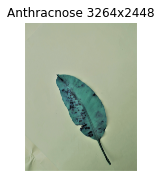

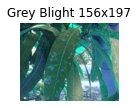

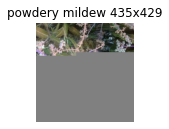

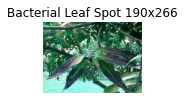

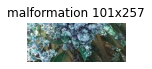

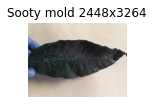

In [47]:
explore_images(train_path)

In [48]:
# create a data generator
datagen = ImageDataGenerator()

In [49]:
EPOCHS = 100
patience = 10

batch_size = 256
image_size = (128, 128)
learning_rate = 0.001

In [50]:
train_ds = datagen.flow_from_directory(train_path, batch_size=batch_size,
                                        target_size=image_size, class_mode='categorical',
                                         shuffle=True, seed=SEED + 20)

Found 1303 images belonging to 6 classes.


In [51]:
test_ds = datagen.flow_from_directory(test_path, batch_size=batch_size,
                                        target_size=image_size, class_mode='categorical',
                                         shuffle=False)

Found 538 images belonging to 6 classes.


In [52]:
val_ds = datagen.flow_from_directory(val_path, batch_size=batch_size,
                                        target_size=image_size, class_mode='categorical',
                                         shuffle=False)

Found 1510 images belonging to 6 classes.


In [56]:
def BuildModel (pretrained):
      ''' Transfer Learning '''
      
      base_model = pretrained(include_top=False, weights='imagenet', input_shape=(128, 128,3)) #include_top=False to remove the last layer 

      for layer in base_model.layers:
          layer.trainable = False   #freeze trainable layers

      x = base_model.output
      x = GlobalAveragePooling2D()(x)
      x = Dropout(0.1)(x)
      x = BatchNormalization()(x)
      x = Dense(256, activation='relu')(x)
      x = Dropout(0.2)(x)
      x = BatchNormalization()(x)
      output = Dense(6, activation='softmax')(x) 

      model = Model(base_model.input, output)

      return model

In [57]:
model = BuildModel(VGG16)

In [58]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [59]:
earlystop = EarlyStopping(monitor='loss', patience=patience, verbose=1, restore_best_weights=True)
chkpt_path = os.path.join("./", 'Classifier.h5', )
checkpoint = ModelCheckpoint(chkpt_path, monitor='loss',mode='auto', verbose=1, save_best_only=True)

In [62]:
history = model.fit(train_ds, epochs=EPOCHS, callbacks=[earlystop, checkpoint], verbose=1, validation_data=val_ds)

Epoch 1/100
6/6 [==============================] - 757s 128s/step - loss: 2.1206 - accuracy: 0.2579 - val_loss: 3.0644 - val_accuracy: 0.3755

Epoch 00001: loss improved from inf to 2.12063, saving model to ./Classifier.h5
Epoch 2/100
6/6 [==============================] - 47s 9s/step - loss: 1.5385 - accuracy: 0.4305 - val_loss: 2.2933 - val_accuracy: 0.4921

Epoch 00002: loss improved from 2.12063 to 1.53849, saving model to ./Classifier.h5
Epoch 3/100
6/6 [==============================] - 48s 9s/step - loss: 1.2301 - accuracy: 0.5510 - val_loss: 1.6169 - val_accuracy: 0.5808

Epoch 00003: loss improved from 1.53849 to 1.23014, saving model to ./Classifier.h5
Epoch 4/100
6/6 [==============================] - 47s 8s/step - loss: 1.0727 - accuracy: 0.6117 - val_loss: 1.2284 - val_accuracy: 0.6397

Epoch 00004: loss improved from 1.23014 to 1.07272, saving model to ./Classifier.h5
Epoch 5/100
6/6 [==============================] - 47s 8s/step - loss: 0.9829 - accuracy: 0.6355 - val_lo

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

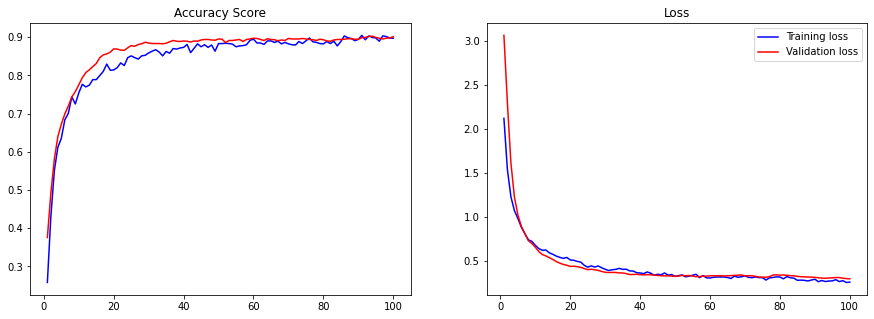

In [70]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
trained_epochs = range(1, len(acc) + 1)

# Training loss accuracy
axes[0].plot(trained_epochs, acc, 'b', label='Training accurarcy')
axes[0].plot(trained_epochs, val_acc, 'r', label='Validation accurarcy')

axes[1].plot(trained_epochs, loss, 'b', label='Training loss')
axes[1].plot(trained_epochs, val_loss, 'r', label='Validation loss')

axes[0].set_title('Accuracy Score')
axes[1].set_title('Loss')
plt.legend()

plt.show()